<a href="https://colab.research.google.com/github/insarov2014/Toronto-Island-Ferry-Ticket-Counts-Forecast/blob/main/SalesCount_Forecast_Appendix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import logging

import pandas as pd
from utilsforecast.plotting import plot_series

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS


In [ ]:
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/WrittenTest_Manitoba')

In [ ]:
def load_data(file):
    # generic data processing function
    df = pd.read_csv(file,
                dtype={'_id':int, 'Sales Count': int, 'Sales Count':int},
                parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    # convert to time-aware
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('d').sum()
    # engineer some time features
    df_daily['monthly'] = df_daily.reset_index().Timestamp.dt.month.values
    df_daily['quarter'] = df_daily.reset_index().Timestamp.dt.quarter.values
    return df_daily

In [ ]:
file = "/content/gdrive/My Drive/Colab Notebooks/WrittenTest_Manitoba/Toronto Island Ferry Ticket Counts.csv"
df = load_data(file)

In [ ]:
df.shape

(3690, 5)

In [ ]:
# What does the data look like?
df.head()

,_id,Redemption Count,Sales Count,monthly,quarter
Timestamp,,,,,
2015-05-01,985646,1,4,5,2
2015-05-02,0,0,0,5,2
2015-05-03,0,0,0,5,2
2015-05-04,4681600,12,75,5,2
2015-05-05,11332905,537,549,5,2


In [ ]:
df_new = df['Sales Count'].copy().reset_index()
df_new['unique_id'] = 1
df_new.columns = ['ds', 'y', 'unique_id']
df_new

,ds,y,unique_id
0,2015-05-01,4,1
1,2015-05-02,0,1
2,2015-05-03,0,1
3,2015-05-04,75,1
4,2015-05-05,549,1
...,...,...,...
3685,2025-06-02,5409,1
3686,2025-06-03,5503,1
3687,2025-06-04,5423,1
3688,2025-06-05,2919,1


In [ ]:
train_neural = df_new.iloc[:-365].copy()
test_neural = df_new.iloc[-365:].copy()

print("Min tr Date: " , train_neural.ds.min())
print("Max tr Date: " , train_neural.ds.max())
print("Min te Date: " , train_neural.ds.min())
print("Max te Date: " , train_neural.ds.max())

Min tr Date:  2015-05-01 00:00:00
Max tr Date:  2024-06-06 00:00:00
Min te Date:  2015-05-01 00:00:00
Max te Date:  2024-06-06 00:00:00


In [ ]:
print(train_neural.shape)
print(test_neural.shape)

(3325, 3)
(365, 3)


#NBEATS and NHITS models

In [ ]:
%%time
# Fit and predict with NBEATS and NHITS models
horizon = 365
models = [NBEATS(input_size=1 * horizon, h=horizon, max_steps=100, enable_progress_bar=False),
          NHITS(input_size=1 * horizon, h=horizon, max_steps=100, enable_progress_bar=False)]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=train_neural)
Y_hat_df = nf.predict()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


CPU times: user 2min 26s, sys: 846 ms, total: 2min 27s
Wall time: 2min 26s


In [ ]:
Y_hat_df

,unique_id,ds,NBEATS,NHITS
0,1,2024-06-07,6698.244141,5566.924805
1,1,2024-06-08,7762.031738,6458.223145
2,1,2024-06-09,8125.921875,7184.585938
3,1,2024-06-10,7524.086426,7563.465820
4,1,2024-06-11,6264.965332,6502.266113
...,...,...,...,...
360,1,2025-06-02,2624.646729,3162.339355
361,1,2025-06-03,2162.363037,2949.973633
362,1,2025-06-04,2770.199707,2446.581543
363,1,2025-06-05,1599.364868,2259.912598


In [ ]:
new_neural = pd.merge(test_neural, Y_hat_df, how='inner', on=['ds', 'unique_id'])
new_neural

,ds,y,unique_id,NBEATS,NHITS
0,2024-06-07,3488,1,6698.244141,5566.924805
1,2024-06-08,9330,1,7762.031738,6458.223145
2,2024-06-09,4586,1,8125.921875,7184.585938
3,2024-06-10,4072,1,7524.086426,7563.465820
4,2024-06-11,4387,1,6264.965332,6502.266113
...,...,...,...,...,...
360,2025-06-02,5409,1,2624.646729,3162.339355
361,2025-06-03,5503,1,2162.363037,2949.973633
362,2025-06-04,5423,1,2770.199707,2446.581543
363,2025-06-05,2919,1,1599.364868,2259.912598


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse

In [ ]:
print(f"MAE from NBEATS Model: {mae(new_neural['y'], new_neural['NBEATS']):.2f}")
print(f"RMSE from NBEATS Model: {rmse(new_neural['y'], new_neural['NBEATS']):.2f}")
print(f"MSE from NBEATS Model: {mse(new_neural['y'], new_neural['NBEATS']):.2e}")
print(f"MAPE from NBEATS Model: {mape(new_neural['y'], new_neural['NBEATS']):.2e}")

MAE from NBEATS Model: 1485.58
RMSE from NBEATS Model: 2437.48
MSE from NBEATS Model: 5.94e+06
MAPE from NBEATS Model: 4.58e+15


In [ ]:
print(f"MAE from NHITS Model: {mae(new_neural['y'], new_neural['NHITS']):.2f}")
print(f"RMSE from NHITS Model: {rmse(new_neural['y'], new_neural['NHITS']):.2f}")
print(f"MSE from NHITS Model: {mse(new_neural['y'], new_neural['NHITS']):.2e}")
print(f"MAPE from NHITS Model: {mape(new_neural['y'], new_neural['NHITS']):.2e}")

MAE from NHITS Model: 1687.77
RMSE from NHITS Model: 2503.83
MSE from NHITS Model: 6.27e+06
MAPE from NHITS Model: 1.81e+16


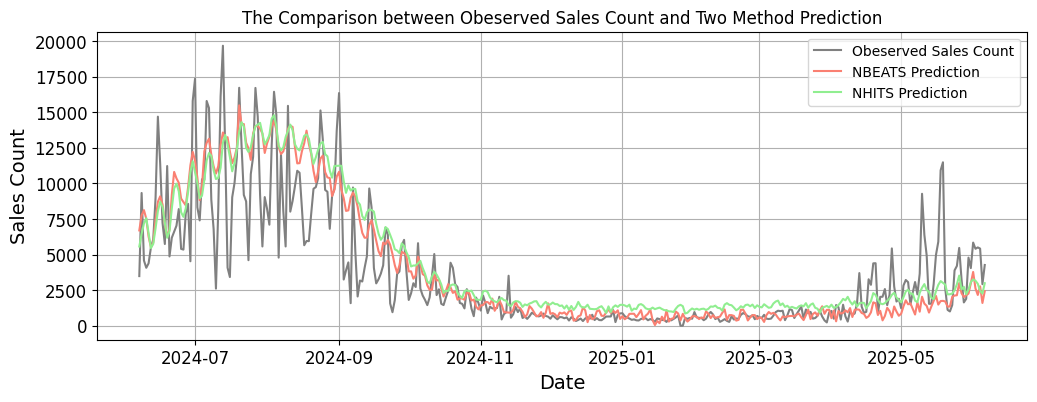

CPU times: user 379 ms, sys: 7.84 ms, total: 387 ms
Wall time: 416 ms


In [ ]:
%%time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(new_neural['ds'], new_neural['y'], color='grey', label='Obeserved Sales Count')
plt.plot(new_neural['ds'], new_neural['NBEATS'], color='salmon', label='NBEATS Prediction')
plt.plot(new_neural['ds'], new_neural['NHITS'], color='lightgreen', label='NHITS Prediction')
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.title('The Comparison between Obeserved Sales Count and Two Method Prediction')
plt.legend()
plt.grid(True)
# plt.xticks(rotation=45)
plt.show()

#Try 3 more models

#MLP

In [ ]:
%%time
np.random.seed(42)
tf.random.set_seed(42)
from neuralforecast import NeuralForecast
from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import DistributionLoss

horizon =365
MLP_model = MLP(h=365, input_size=2 * horizon,
            loss=DistributionLoss(distribution='Normal', level=[90]),
            scaler_type='robust',
            learning_rate=1e-3,
            max_steps=100,
            val_check_steps=10,
            early_stop_patience_steps=2)

MLP_fcst = NeuralForecast(
    models=[MLP_model],
    freq='D'
)
MLP_fcst.fit(df=train_neural , val_size=365)
MLP_forecasts = MLP_fcst.predict(futr_df=test_neural)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

CPU times: user 54.2 s, sys: 414 ms, total: 54.7 s
Wall time: 56 s


In [ ]:
MLP_forecasts

,unique_id,ds,MLP,MLP-median,MLP-lo-90,MLP-hi-90
0,1,2024-06-07,5965.502930,5885.068359,-2508.320801,14553.507812
1,1,2024-06-08,6733.491211,6652.580078,-3470.003418,17438.789062
2,1,2024-06-09,7626.151855,7571.208008,-5181.531738,21136.027344
3,1,2024-06-10,6840.328125,6830.272461,-478.739288,13410.683594
4,1,2024-06-11,6381.849609,6216.311523,-2007.193359,14766.620117
...,...,...,...,...,...,...
360,1,2025-06-02,7661.527344,7474.330078,-1924.662598,17321.585938
361,1,2025-06-03,6603.942871,6551.437500,-3337.088379,16903.312500
362,1,2025-06-04,8202.224609,8264.228516,-502.237488,17058.806641
363,1,2025-06-05,5997.024902,5807.424805,-3479.291260,16326.265625


In [ ]:
new_MLP = test_neural.copy()
new_MLP['MLP prediction'] = MLP_forecasts['MLP'].to_numpy()
new_MLP

,ds,y,unique_id,MLP prediction
3325,2024-06-07,3488,1,5965.502930
3326,2024-06-08,9330,1,6733.491211
3327,2024-06-09,4586,1,7626.151855
3328,2024-06-10,4072,1,6840.328125
3329,2024-06-11,4387,1,6381.849609
...,...,...,...,...
3685,2025-06-02,5409,1,7661.527344
3686,2025-06-03,5503,1,6603.942871
3687,2025-06-04,5423,1,8202.224609
3688,2025-06-05,2919,1,5997.024902


In [ ]:
print(f"MAE from MLP Model: {mae(new_MLP['y'], new_MLP['MLP prediction']):.2f}")
print(f"RMSE from MLP Model: {rmse(new_MLP['y'], new_MLP['MLP prediction']):.2f}")
print(f"MSE from MLP Model: {mse(new_MLP['y'], new_MLP['MLP prediction']):.2e}")
print(f"MAPE from MLP Model: {mape(new_MLP['y'], new_MLP['MLP prediction']):.2e}")

MAE from MLP Model: 1888.98
RMSE from MLP Model: 2774.09
MSE from MLP Model: 7.70e+06
MAPE from MLP Model: 1.39e+16


#RNN

In [ ]:
%%time

from neuralforecast.models import RNN
from neuralforecast.losses.pytorch import MQLoss

np.random.seed(42)
tf.random.set_seed(42)

horizon =365
RNN_fcst = NeuralForecast(
    models=[RNN(h=365,
                input_size=2 * horizon,
                inference_input_size=2 * horizon,
                loss=MQLoss(level=[90]),
                valid_loss=MQLoss(level=[90]),
                scaler_type='standard',
                encoder_n_layers=2,
                encoder_hidden_size=128,
                decoder_hidden_size=128,
                decoder_layers=2,
                max_steps=100,
                )
    ],
    freq='D'
)
RNN_fcst.fit(df=train_neural, val_size=horizon)
RNN_forecasts = RNN_fcst.predict(futr_df=test_neural)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

CPU times: user 8min 53s, sys: 19.1 s, total: 9min 12s
Wall time: 8min 4s


In [ ]:
RNN_forecasts

,unique_id,ds,RNN-median,RNN-lo-90,RNN-hi-90
0,1,2024-06-07,5150.371094,1020.991211,17212.625000
1,1,2024-06-08,4702.543457,965.139160,15599.140625
2,1,2024-06-09,6481.239258,1308.349365,19718.431641
3,1,2024-06-10,5649.149902,986.579102,18865.169922
4,1,2024-06-11,4902.237793,860.353027,16840.673828
...,...,...,...,...,...
360,1,2025-06-02,5063.423828,844.386230,17336.359375
361,1,2025-06-03,5017.365234,900.591064,16820.980469
362,1,2025-06-04,4998.889160,920.610840,16616.970703
363,1,2025-06-05,4621.500488,867.060547,15557.292969


In [ ]:
new_RNN = test_neural.copy()
new_RNN['RNN prediction'] = RNN_forecasts['RNN-median'].to_numpy()
new_RNN

,ds,y,unique_id,RNN prediction
3325,2024-06-07,3488,1,5150.371094
3326,2024-06-08,9330,1,4702.543457
3327,2024-06-09,4586,1,6481.239258
3328,2024-06-10,4072,1,5649.149902
3329,2024-06-11,4387,1,4902.237793
...,...,...,...,...
3685,2025-06-02,5409,1,5063.423828
3686,2025-06-03,5503,1,5017.365234
3687,2025-06-04,5423,1,4998.889160
3688,2025-06-05,2919,1,4621.500488


In [ ]:
print(f"MAE from RNN Model: {mae(new_RNN['y'], new_RNN['RNN prediction']):.2f}")
print(f"RMSE from RNN Model: {rmse(new_RNN['y'], new_RNN['RNN prediction']):.2f}")  #1
print(f"MSE from RNN Model: {mse(new_RNN['y'], new_RNN['RNN prediction']):.2e}")
print(f"MAPE from RNN Model: {mape(new_RNN['y'], new_RNN['RNN prediction']):.2e}")

MAE from RNN Model: 1501.23
RMSE from RNN Model: 2369.30
MSE from RNN Model: 5.61e+06
MAPE from RNN Model: 1.23e+16


#LSTM

In [ ]:
%%time
from neuralforecast.models import LSTM

np.random.seed(42)
tf.random.set_seed(42)

horizon =365
LSTM_nf = NeuralForecast(
    models=[LSTM(h=365,
                 input_size=2 * horizon,
                 loss=DistributionLoss(distribution="Normal", level=[90]),
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=100,
                 recurrent=True,
                 h_train=1,
                 )
    ],
    freq='D'
)

LSTM_nf.fit(df=train_neural)
LSTM_forecasts = LSTM_nf.predict(futr_df=test_neural)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

CPU times: user 12min 45s, sys: 53 s, total: 13min 38s
Wall time: 11min 49s


In [ ]:
LSTM_forecasts

,unique_id,ds,LSTM,LSTM-median,LSTM-lo-90,LSTM-hi-90
0,1,2024-06-07,5692.836914,4726.323242,-5052.601562,16242.036133
1,1,2024-06-08,5689.448730,5058.010742,-4462.690918,16115.411133
2,1,2024-06-09,5714.548828,6623.980469,-3986.831055,15658.548828
3,1,2024-06-10,5755.013672,4897.130371,-6561.747559,15412.899414
4,1,2024-06-11,5803.584473,5666.593262,-6114.647949,14625.886719
...,...,...,...,...,...,...
360,1,2025-06-02,6636.755859,6706.439453,-6552.991211,19122.445312
361,1,2025-06-03,6636.755859,7642.323730,-5857.040039,18995.324219
362,1,2025-06-04,6636.755859,8078.743652,-7659.750488,21095.857422
363,1,2025-06-05,6636.755859,8203.895508,-3847.794189,21532.185547


In [ ]:
new_LSTM = test_neural.copy()
new_LSTM['LSTM prediction'] = LSTM_forecasts['LSTM'].to_numpy()
new_LSTM

,ds,y,unique_id,LSTM prediction
3325,2024-06-07,3488,1,5692.836914
3326,2024-06-08,9330,1,5689.448730
3327,2024-06-09,4586,1,5714.548828
3328,2024-06-10,4072,1,5755.013672
3329,2024-06-11,4387,1,5803.584473
...,...,...,...,...
3685,2025-06-02,5409,1,6636.755859
3686,2025-06-03,5503,1,6636.755859
3687,2025-06-04,5423,1,6636.755859
3688,2025-06-05,2919,1,6636.755859


In [ ]:
print(f"MAE from LSTM Model: {mae(new_LSTM['y'], new_LSTM['LSTM prediction']):.2f}")
print(f"RMSE from LSTM Model: {rmse(new_LSTM['y'], new_LSTM['LSTM prediction']):.2f}")
print(f"MSE from LSTM Model: {mse(new_LSTM['y'], new_LSTM['LSTM prediction']):.2e}")
print(f"MAPE from LSTM Model: {mape(new_LSTM['y'], new_LSTM['LSTM prediction']):.2e}")

MAE from LSTM Model: 4657.20
RMSE from LSTM Model: 5107.30
MSE from LSTM Model: 2.61e+07
MAPE from LSTM Model: 8.19e+16


No one beats Extra Tree, therefore I don't bother tuning them.